In [1]:
import os
import lmdb
import torch
from io import BytesIO
from torch import nn, optim
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.transforms import functional as trans_fn
from PIL import Image
from utils import Logger

# Variables

In [29]:
DATA_IMAGES_PATH = '/Users/alex/Projects/datasets/SUNDATABASE/Images/b/beach/'
DATA_ANNOTATIONS_PATH = '/Users/alex/Projects/datasets/SUNDATABASE/Annotations/b/beach/'

IMAGE_SIZE = 32

# Dataset

In [17]:
def resize_and_convert(img, size, resample, quality=100):
    img = trans_fn.resize(img, size, resample)
    img = trans_fn.center_crop(img, size)
    img = img.convert('RGB')
    buffer = BytesIO()
    img.save(buffer, format='jpeg', quality=quality)
    val = buffer.getvalue()
    
    return img

class PlacesDataset(Dataset):
    def __init__(self, images_path, annots_path, transform=None):
        self.images_path = images_path
        self.annots_path = annots_path
        self.transform = transform

    def __len__(self):
        return len([name for name in os.listdir(self.images_path) if os.path.isfile(self.images_path + name)])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        images = sorted(os.listdir(self.images_path))
        img_path = self.images_path + images[idx]
        
#         annots = sorted(os.listdir(self.annots_path))
#         annot_path = self.annots_path + annots[idx]

        loc_img = Image.open(img_path)
        img = resize_and_convert(loc_img, IMAGE_SIZE, Image.LANCZOS)

        if self.transform is not None:
            img = self.transform(img)

        return img

In [26]:
compose = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])
    ])

# dataset from tutorial
def mnist_data():
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = PlacesDataset(images_path=DATA_IMAGES_PATH, annots_path=DATA_ANNOTATIONS_PATH)

# Create loader with data, so that we can iterate over it
data_loader = DataLoader(data, batch_size=100)

# Num batches
num_batches = len(data_loader)

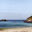

In [27]:
data.__getitem__(idx=5)

# Discriminator

In [19]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = IMAGE_SIZE * IMAGE_SIZE * 3
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator = DiscriminatorNet()

# Generator

In [20]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = IMAGE_SIZE * IMAGE_SIZE * 3
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

# Helpers

In [34]:
# Discriminator Helpers

def images_to_vectors(images):
    return images.view(images.size(0), IMAGE_SIZE * IMAGE_SIZE * 3)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, IMAGE_SIZE, IMAGE_SIZE)

# Generator Helpers

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

# Discriminator Loss
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

# Testing
num_test_samples = 16
test_noise = noise(num_test_samples)

# Train

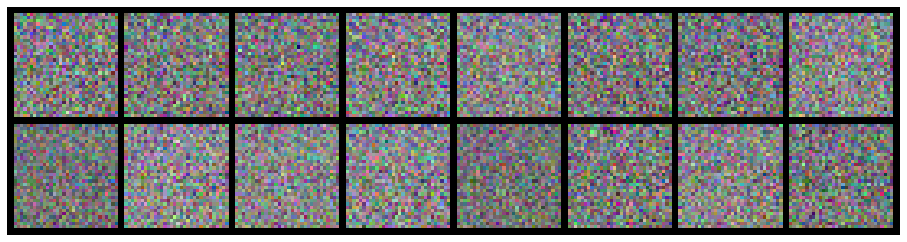

Epoch: [0/200], Batch Num: [0/13]
Discriminator Loss: 1.3881, Generator Loss: 0.6658
D(x): 0.5144, D(G(z)): 0.5148


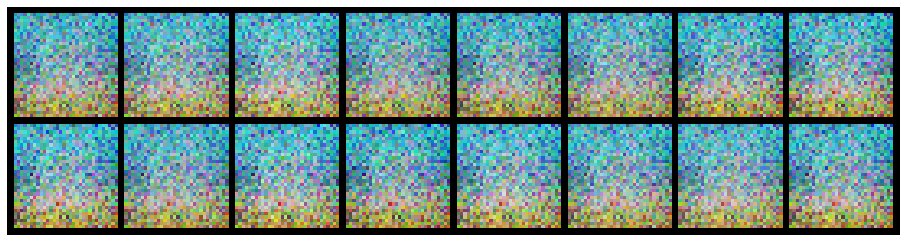

Epoch: [1/200], Batch Num: [0/13]
Discriminator Loss: 1.0707, Generator Loss: 0.6423
D(x): 0.8942, D(G(z)): 0.6147


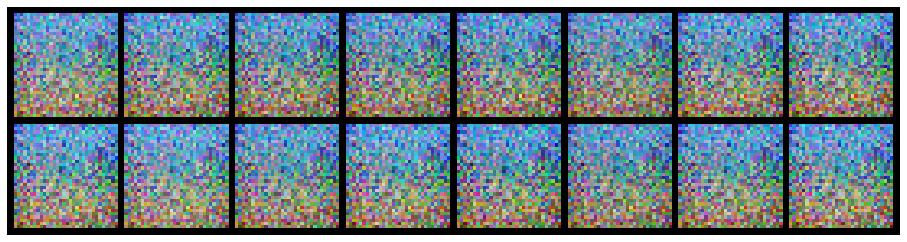

Epoch: [2/200], Batch Num: [0/13]
Discriminator Loss: 1.1562, Generator Loss: 1.4636
D(x): 0.7669, D(G(z)): 0.5265


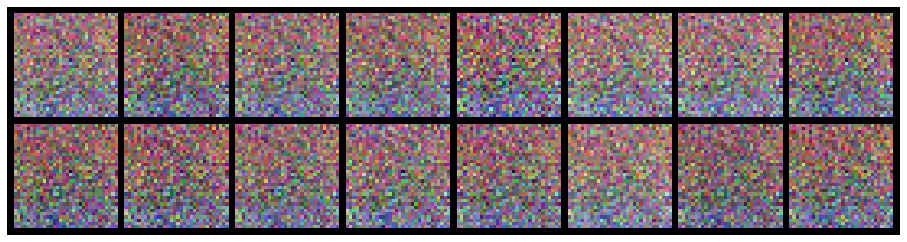

Epoch: [3/200], Batch Num: [0/13]
Discriminator Loss: 1.2786, Generator Loss: 0.6699
D(x): 0.9530, D(G(z)): 0.6942


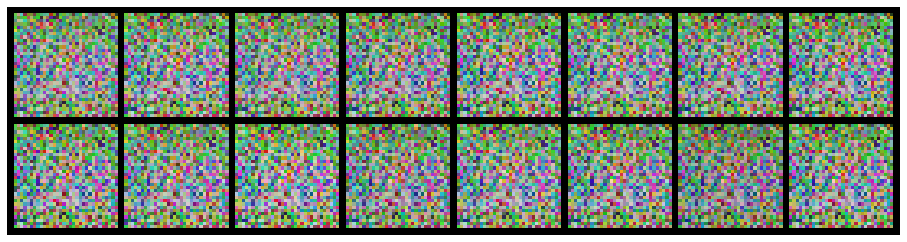

Epoch: [4/200], Batch Num: [0/13]
Discriminator Loss: 0.5597, Generator Loss: 2.9861
D(x): 0.8242, D(G(z)): 0.1535


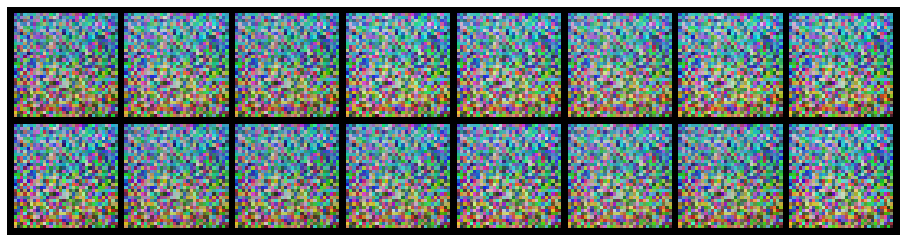

Epoch: [5/200], Batch Num: [0/13]
Discriminator Loss: 3.2971, Generator Loss: 0.1670
D(x): 0.7402, D(G(z)): 0.9362


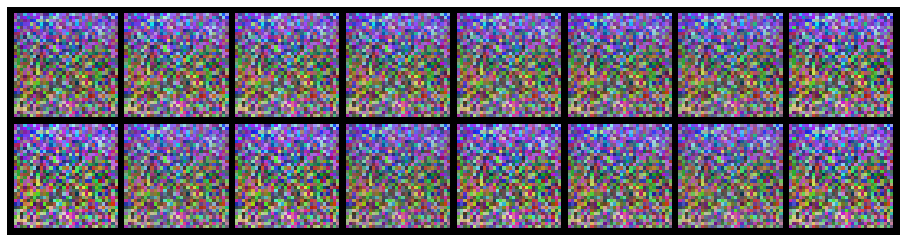

Epoch: [6/200], Batch Num: [0/13]
Discriminator Loss: 0.3184, Generator Loss: 3.0529
D(x): 0.8724, D(G(z)): 0.1358


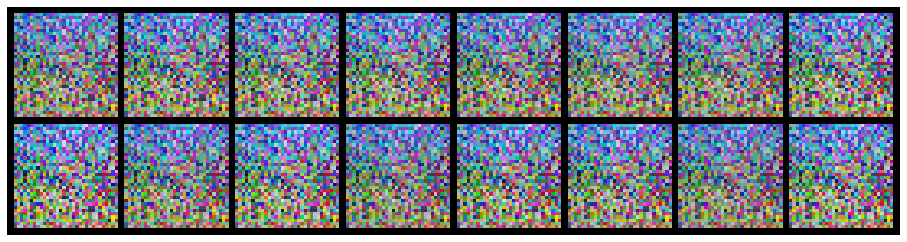

Epoch: [7/200], Batch Num: [0/13]
Discriminator Loss: 0.7351, Generator Loss: 2.6713
D(x): 0.8090, D(G(z)): 0.3744


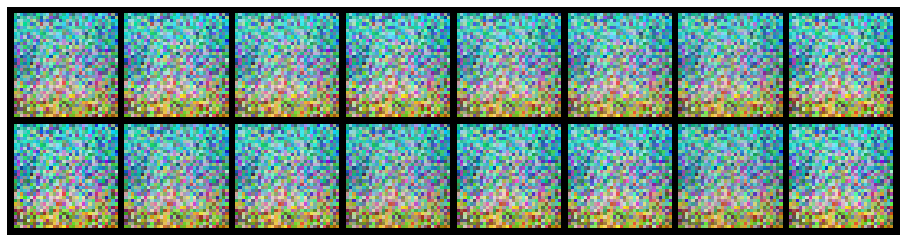

Epoch: [8/200], Batch Num: [0/13]
Discriminator Loss: 0.4381, Generator Loss: 3.8710
D(x): 0.7759, D(G(z)): 0.1001


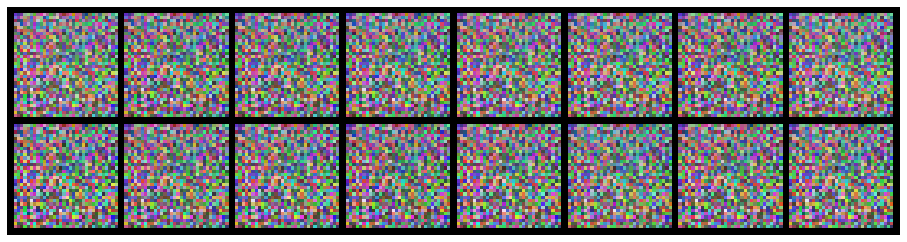

Epoch: [9/200], Batch Num: [0/13]
Discriminator Loss: 0.9684, Generator Loss: 1.5786
D(x): 0.7296, D(G(z)): 0.4054


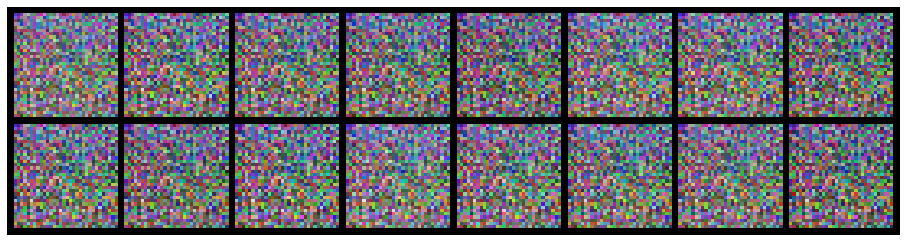

Epoch: [10/200], Batch Num: [0/13]
Discriminator Loss: 0.1348, Generator Loss: 4.6404
D(x): 0.9129, D(G(z)): 0.0170


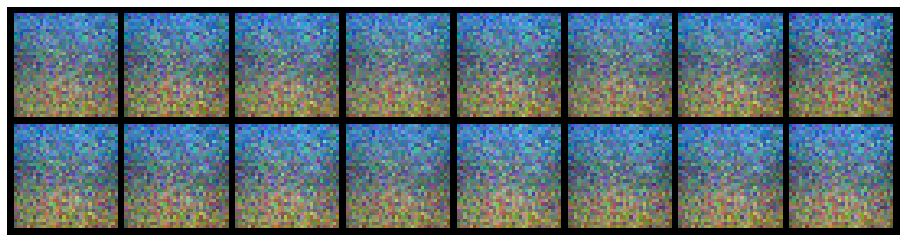

Epoch: [11/200], Batch Num: [0/13]
Discriminator Loss: 0.7963, Generator Loss: 0.8341
D(x): 0.9672, D(G(z)): 0.5253


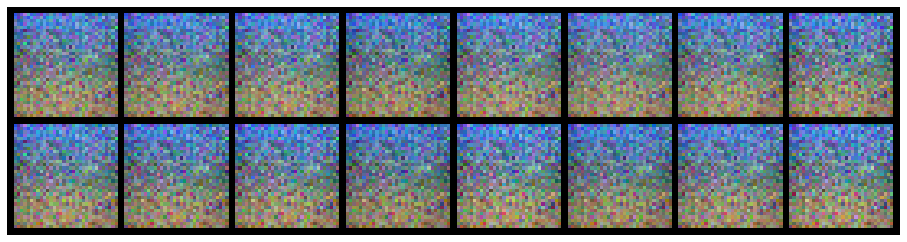

Epoch: [12/200], Batch Num: [0/13]
Discriminator Loss: 0.3425, Generator Loss: 1.9836
D(x): 0.9061, D(G(z)): 0.1822


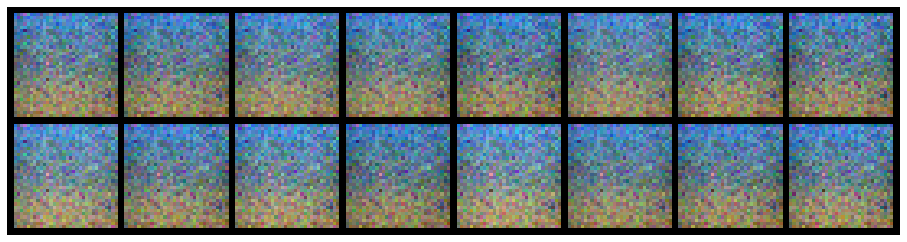

Epoch: [13/200], Batch Num: [0/13]
Discriminator Loss: 0.2436, Generator Loss: 2.3123
D(x): 0.9237, D(G(z)): 0.1188


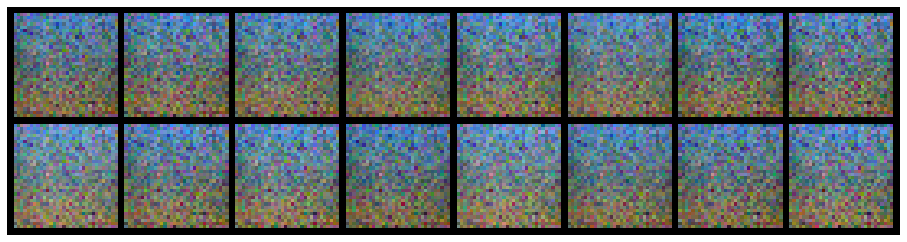

Epoch: [14/200], Batch Num: [0/13]
Discriminator Loss: 0.6738, Generator Loss: 1.2099
D(x): 0.9163, D(G(z)): 0.4073


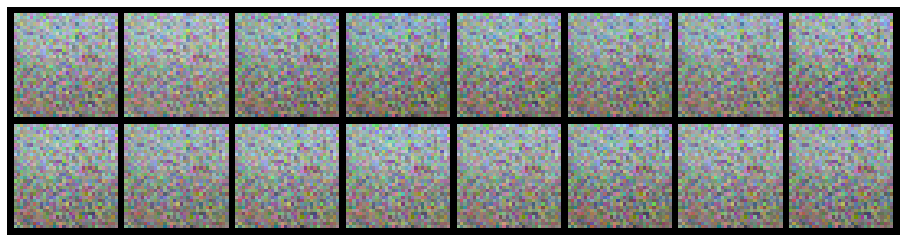

Epoch: [15/200], Batch Num: [0/13]
Discriminator Loss: 1.1574, Generator Loss: 0.8077
D(x): 0.8591, D(G(z)): 0.5659


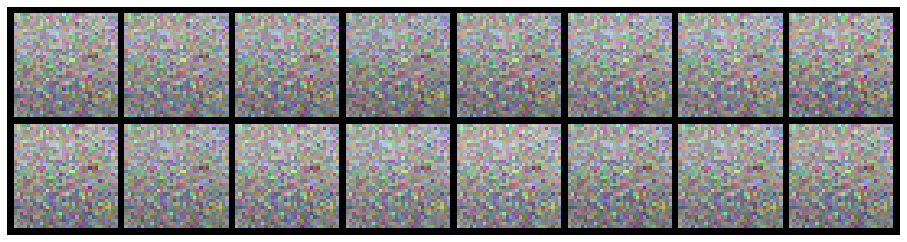

Epoch: [16/200], Batch Num: [0/13]
Discriminator Loss: 0.3832, Generator Loss: 2.0473
D(x): 0.9476, D(G(z)): 0.2708


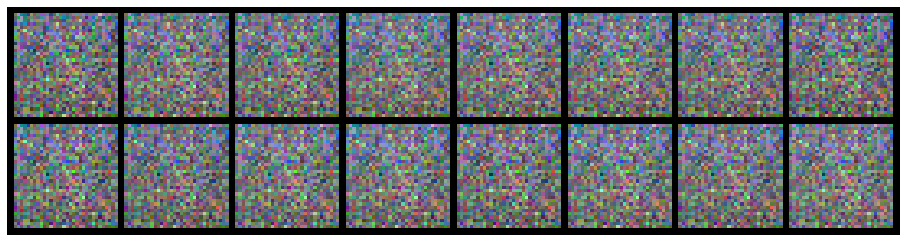

Epoch: [17/200], Batch Num: [0/13]
Discriminator Loss: 0.7633, Generator Loss: 1.5323
D(x): 0.9358, D(G(z)): 0.4833


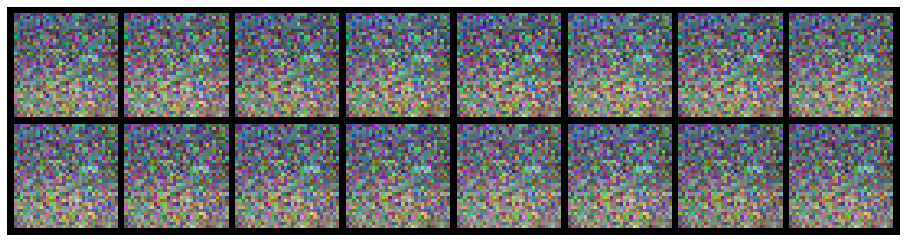

Epoch: [18/200], Batch Num: [0/13]
Discriminator Loss: 1.0050, Generator Loss: 1.3205
D(x): 0.9744, D(G(z)): 0.5879


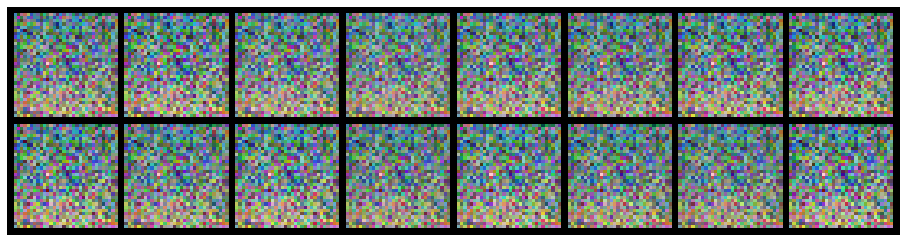

Epoch: [19/200], Batch Num: [0/13]
Discriminator Loss: 0.8089, Generator Loss: 7.0894
D(x): 0.8303, D(G(z)): 0.0782


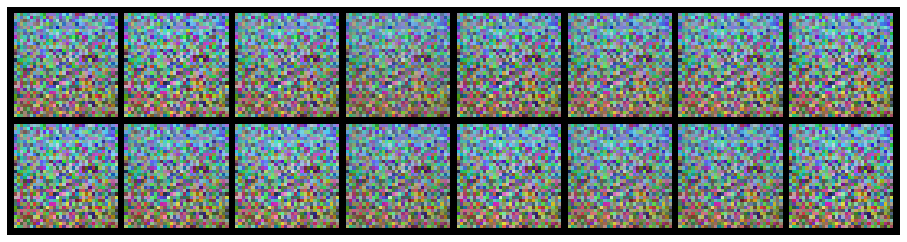

Epoch: [20/200], Batch Num: [0/13]
Discriminator Loss: 0.6227, Generator Loss: 7.4335
D(x): 0.8621, D(G(z)): 0.2249


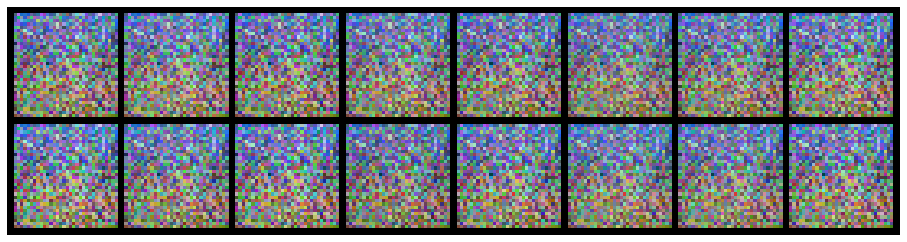

Epoch: [21/200], Batch Num: [0/13]
Discriminator Loss: 0.4822, Generator Loss: 6.4851
D(x): 0.7901, D(G(z)): 0.0206


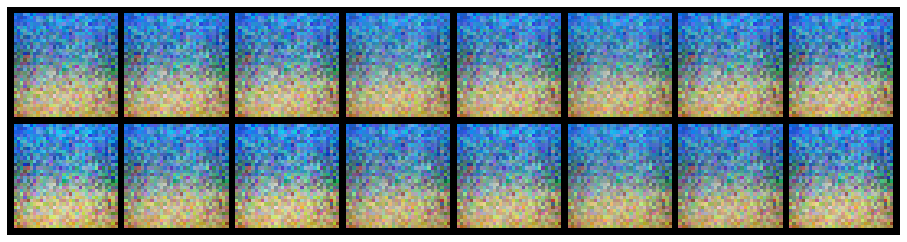

Epoch: [22/200], Batch Num: [0/13]
Discriminator Loss: 0.4509, Generator Loss: 4.9665
D(x): 0.9077, D(G(z)): 0.2222


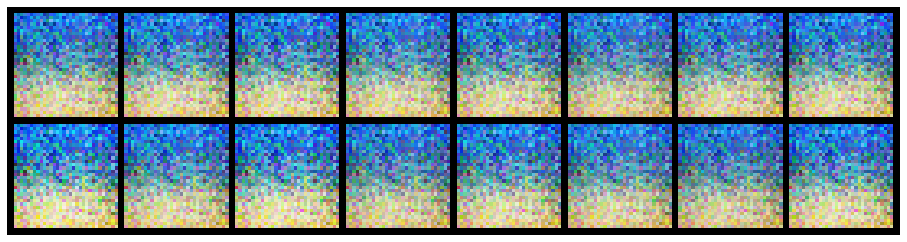

Epoch: [23/200], Batch Num: [0/13]
Discriminator Loss: 0.2601, Generator Loss: 6.8230
D(x): 0.8916, D(G(z)): 0.0208


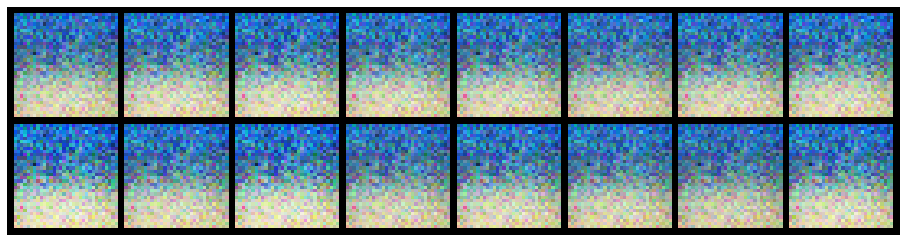

Epoch: [24/200], Batch Num: [0/13]
Discriminator Loss: 1.2323, Generator Loss: 4.9762
D(x): 0.8531, D(G(z)): 0.4374


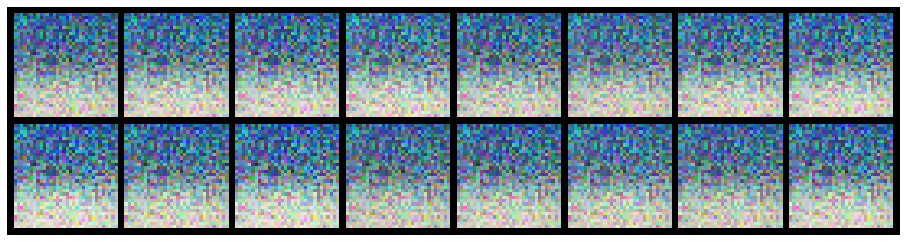

Epoch: [25/200], Batch Num: [0/13]
Discriminator Loss: 0.1037, Generator Loss: 6.4781
D(x): 0.9440, D(G(z)): 0.0245


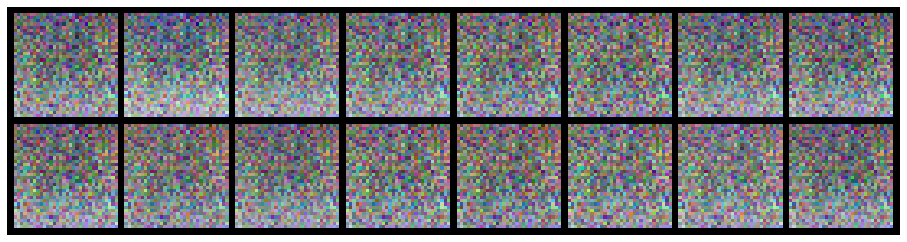

Epoch: [26/200], Batch Num: [0/13]
Discriminator Loss: 0.5725, Generator Loss: 3.6566
D(x): 0.8586, D(G(z)): 0.0620


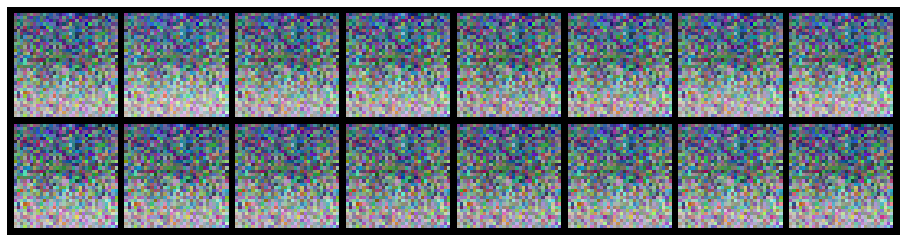

Epoch: [27/200], Batch Num: [0/13]
Discriminator Loss: 0.0734, Generator Loss: 4.2993
D(x): 0.9883, D(G(z)): 0.0578


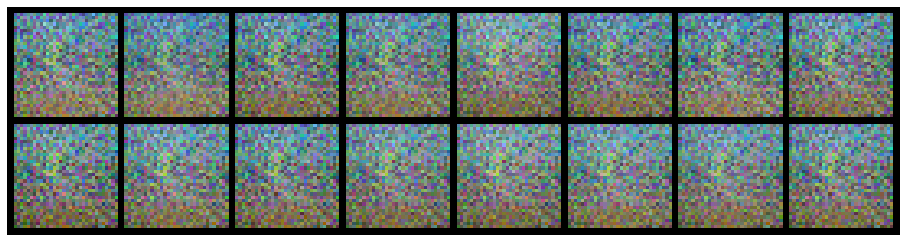

Epoch: [28/200], Batch Num: [0/13]
Discriminator Loss: 4.3763, Generator Loss: 0.3308
D(x): 0.9306, D(G(z)): 0.9522


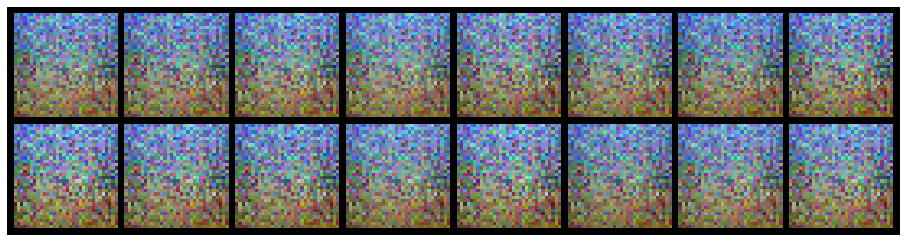

Epoch: [29/200], Batch Num: [0/13]
Discriminator Loss: 1.3288, Generator Loss: 2.9011
D(x): 0.8315, D(G(z)): 0.3762


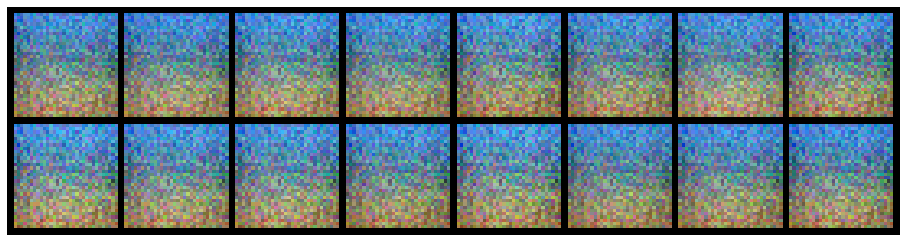

Epoch: [30/200], Batch Num: [0/13]
Discriminator Loss: 0.9405, Generator Loss: 2.6759
D(x): 0.7246, D(G(z)): 0.2222


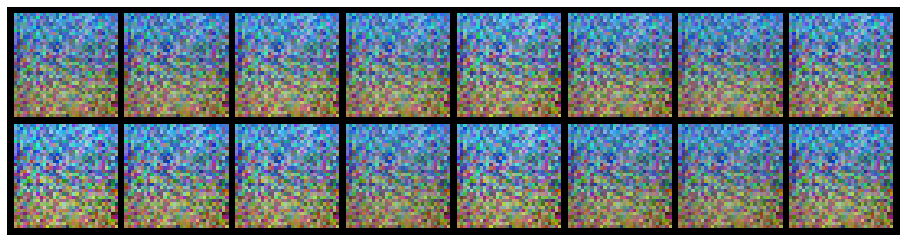

Epoch: [31/200], Batch Num: [0/13]
Discriminator Loss: 0.7111, Generator Loss: 3.8435
D(x): 0.8195, D(G(z)): 0.2836


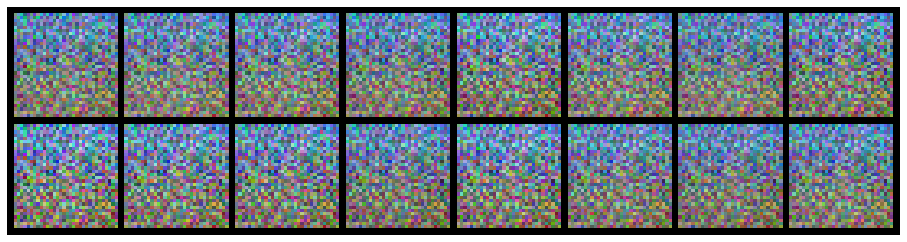

Epoch: [32/200], Batch Num: [0/13]
Discriminator Loss: 0.2455, Generator Loss: 3.7408
D(x): 0.9165, D(G(z)): 0.1116


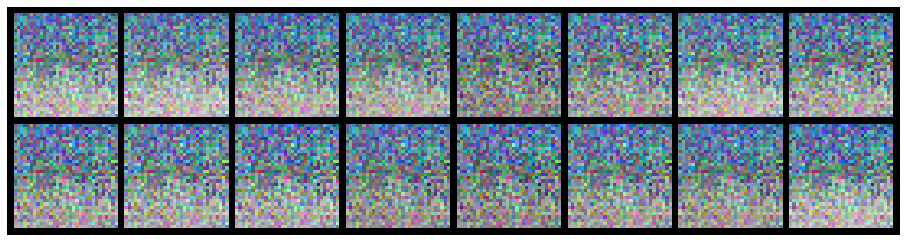

Epoch: [33/200], Batch Num: [0/13]
Discriminator Loss: 0.3665, Generator Loss: 1.9360
D(x): 0.9737, D(G(z)): 0.2623


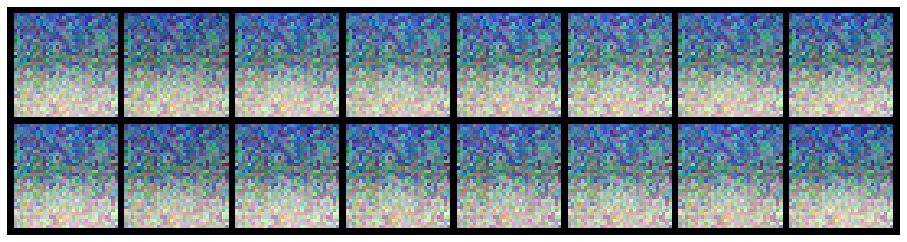

Epoch: [34/200], Batch Num: [0/13]
Discriminator Loss: 0.2097, Generator Loss: 4.7246
D(x): 0.9100, D(G(z)): 0.0167


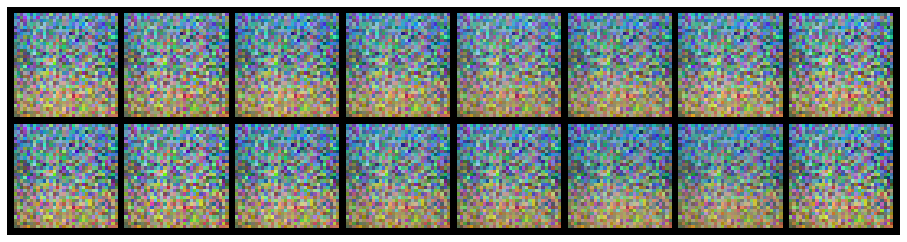

Epoch: [35/200], Batch Num: [0/13]
Discriminator Loss: 0.5393, Generator Loss: 4.7436
D(x): 0.8755, D(G(z)): 0.0868


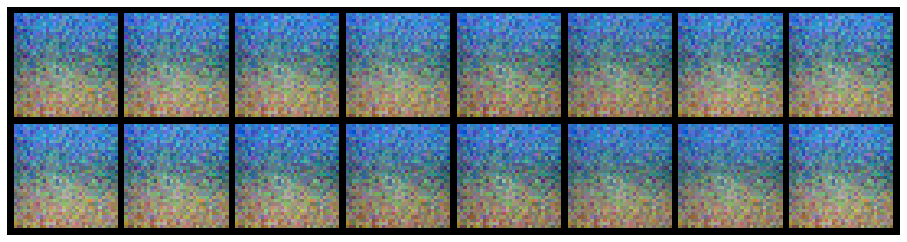

Epoch: [36/200], Batch Num: [0/13]
Discriminator Loss: 0.5757, Generator Loss: 3.6572
D(x): 0.9219, D(G(z)): 0.3195


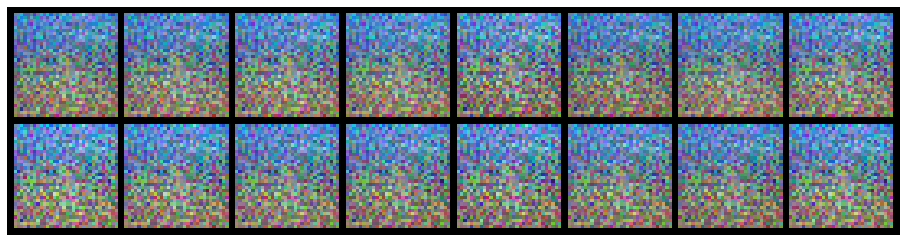

Epoch: [37/200], Batch Num: [0/13]
Discriminator Loss: 0.5958, Generator Loss: 3.7347
D(x): 0.8117, D(G(z)): 0.0571


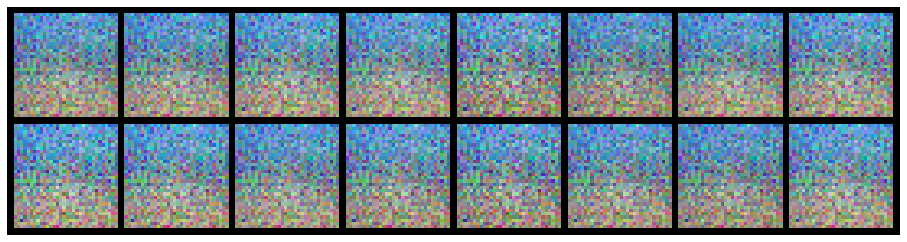

Epoch: [38/200], Batch Num: [0/13]
Discriminator Loss: 0.1643, Generator Loss: 3.0861
D(x): 0.9686, D(G(z)): 0.1142


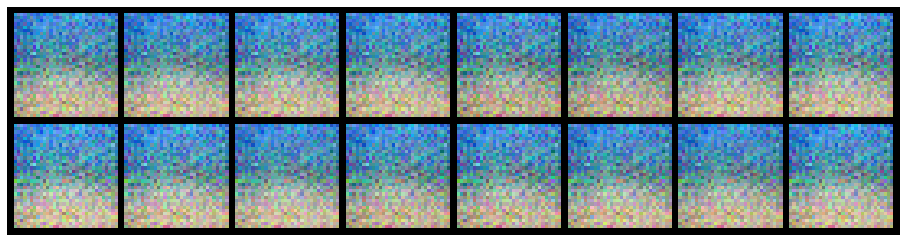

Epoch: [39/200], Batch Num: [0/13]
Discriminator Loss: 0.5415, Generator Loss: 2.5922
D(x): 0.8685, D(G(z)): 0.2522


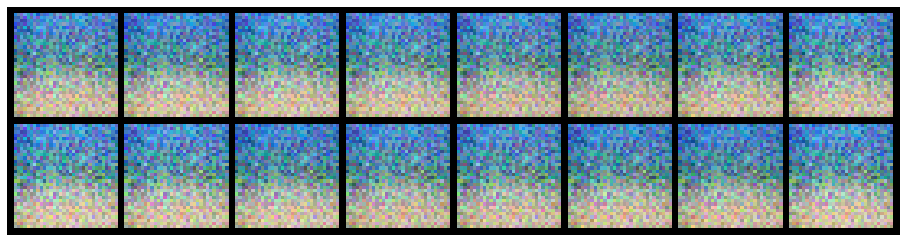

Epoch: [40/200], Batch Num: [0/13]
Discriminator Loss: 0.7244, Generator Loss: 2.8558
D(x): 0.8221, D(G(z)): 0.1050


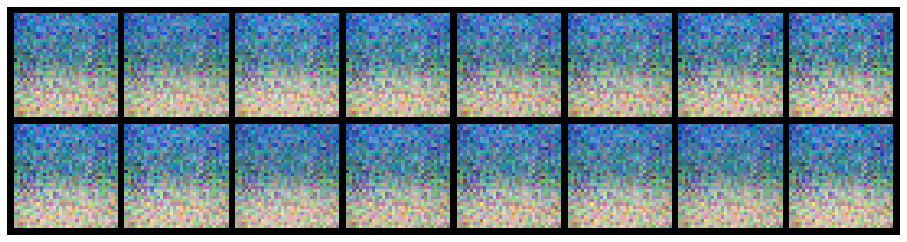

Epoch: [41/200], Batch Num: [0/13]
Discriminator Loss: 0.3047, Generator Loss: 3.2040
D(x): 0.9140, D(G(z)): 0.1222


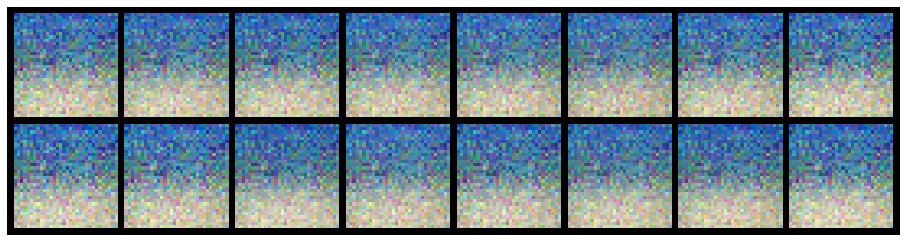

Epoch: [42/200], Batch Num: [0/13]
Discriminator Loss: 1.0224, Generator Loss: 2.9637
D(x): 0.8516, D(G(z)): 0.3104


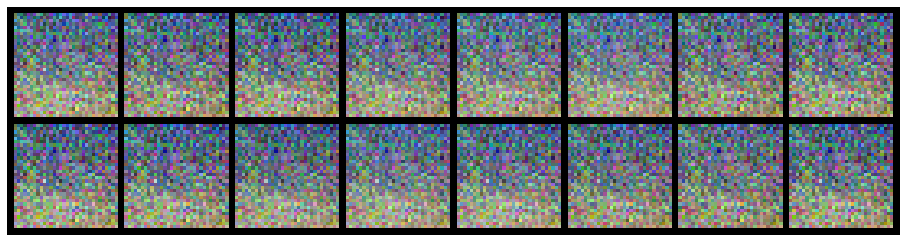

Epoch: [43/200], Batch Num: [0/13]
Discriminator Loss: 1.0890, Generator Loss: 5.1062
D(x): 0.8166, D(G(z)): 0.0605


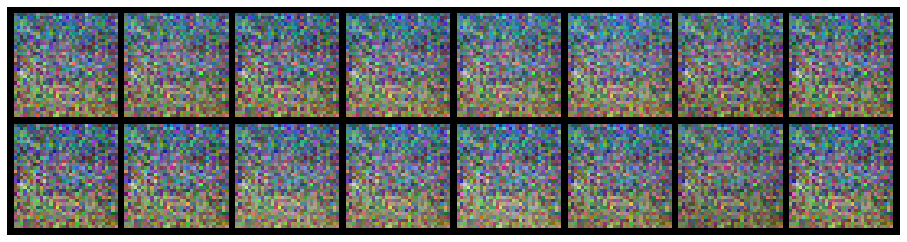

Epoch: [44/200], Batch Num: [0/13]
Discriminator Loss: 0.2211, Generator Loss: 3.8900
D(x): 0.9234, D(G(z)): 0.0584


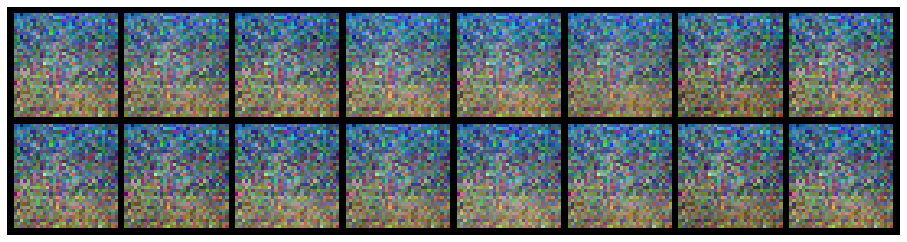

Epoch: [45/200], Batch Num: [0/13]
Discriminator Loss: 0.6315, Generator Loss: 2.9661
D(x): 0.8431, D(G(z)): 0.1412


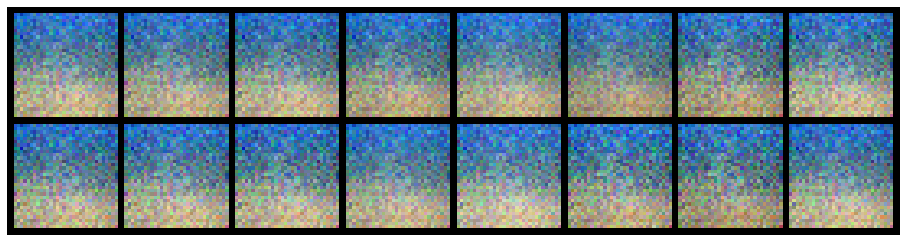

Epoch: [46/200], Batch Num: [0/13]
Discriminator Loss: 0.4376, Generator Loss: 2.2186
D(x): 0.8961, D(G(z)): 0.1962


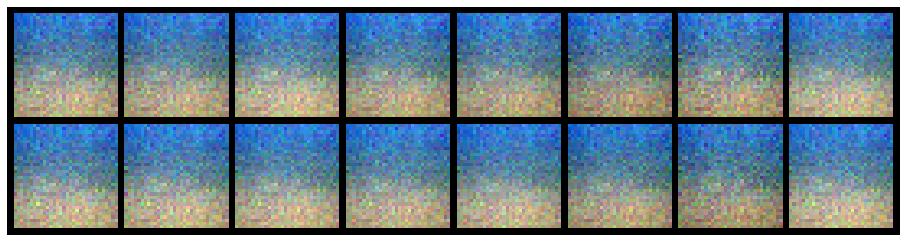

Epoch: [47/200], Batch Num: [0/13]
Discriminator Loss: 0.8034, Generator Loss: 1.7150
D(x): 0.8575, D(G(z)): 0.3357


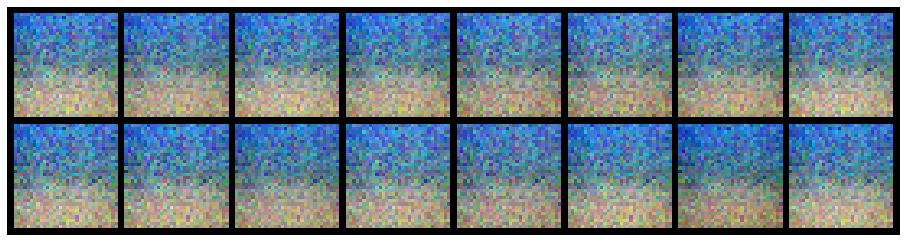

Epoch: [48/200], Batch Num: [0/13]
Discriminator Loss: 1.0416, Generator Loss: 1.7137
D(x): 0.8528, D(G(z)): 0.3906


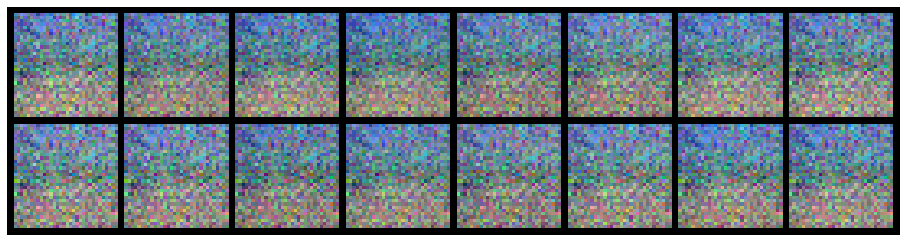

Epoch: [49/200], Batch Num: [0/13]
Discriminator Loss: 0.7340, Generator Loss: 1.7078
D(x): 0.8192, D(G(z)): 0.2837


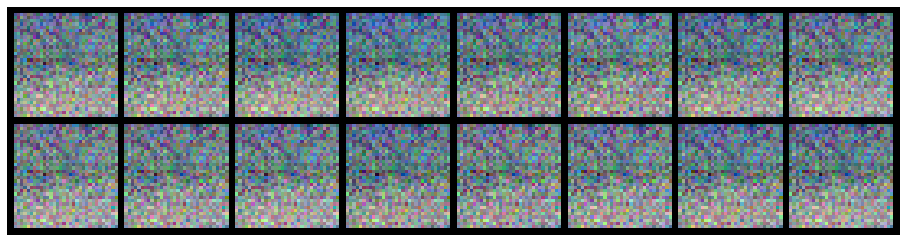

Epoch: [50/200], Batch Num: [0/13]
Discriminator Loss: 0.3870, Generator Loss: 1.9437
D(x): 0.9103, D(G(z)): 0.2157


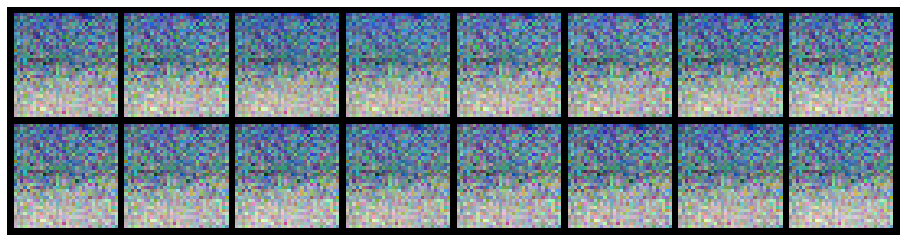

Epoch: [51/200], Batch Num: [0/13]
Discriminator Loss: 0.1328, Generator Loss: 2.8454
D(x): 0.9701, D(G(z)): 0.0901


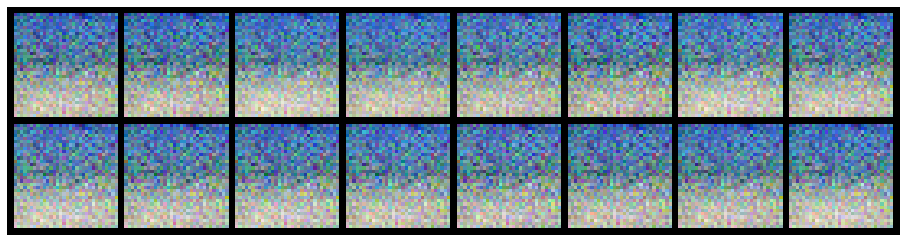

Epoch: [52/200], Batch Num: [0/13]
Discriminator Loss: 0.1044, Generator Loss: 3.0148
D(x): 0.9735, D(G(z)): 0.0699


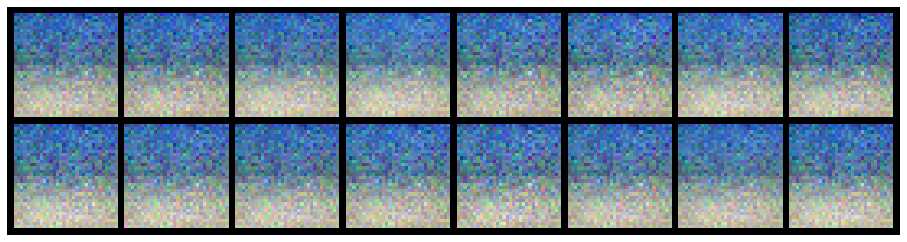

Epoch: [53/200], Batch Num: [0/13]
Discriminator Loss: 0.2841, Generator Loss: 2.3787
D(x): 0.9326, D(G(z)): 0.1604


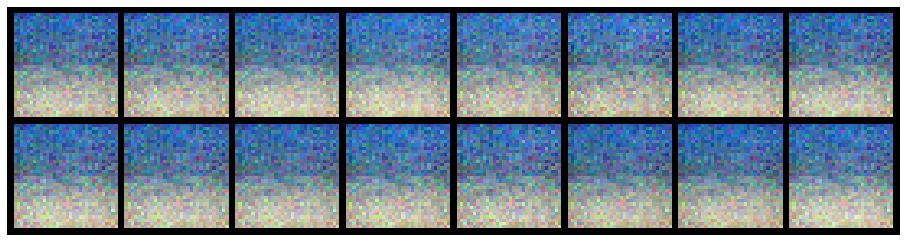

Epoch: [54/200], Batch Num: [0/13]
Discriminator Loss: 0.9207, Generator Loss: 1.4458
D(x): 0.8660, D(G(z)): 0.3265


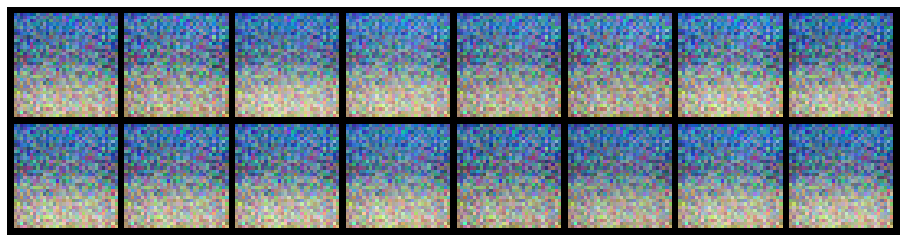

Epoch: [55/200], Batch Num: [0/13]
Discriminator Loss: 0.5696, Generator Loss: 2.0958
D(x): 0.8995, D(G(z)): 0.1848


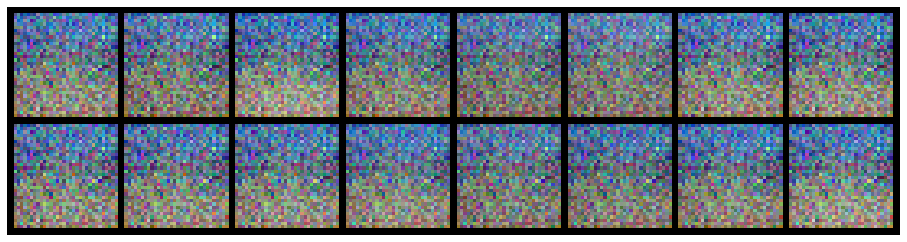

Epoch: [56/200], Batch Num: [0/13]
Discriminator Loss: 1.2702, Generator Loss: 2.0993
D(x): 0.8745, D(G(z)): 0.3814


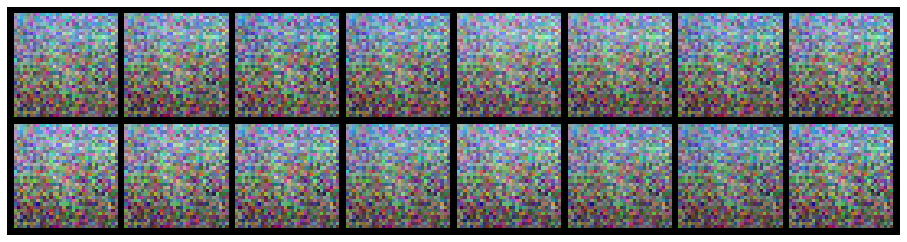

Epoch: [57/200], Batch Num: [0/13]
Discriminator Loss: 0.4418, Generator Loss: 5.7891
D(x): 0.8930, D(G(z)): 0.1581


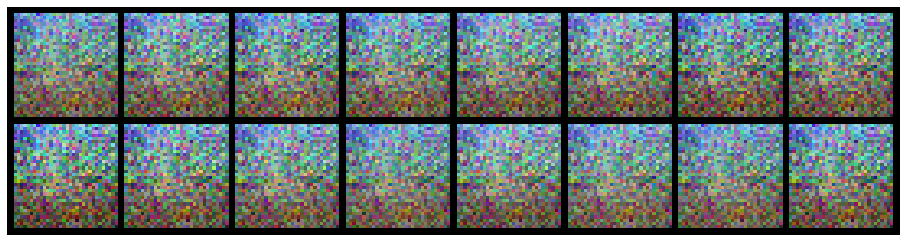

Epoch: [58/200], Batch Num: [0/13]
Discriminator Loss: 0.8434, Generator Loss: 6.4988
D(x): 0.8866, D(G(z)): 0.1973


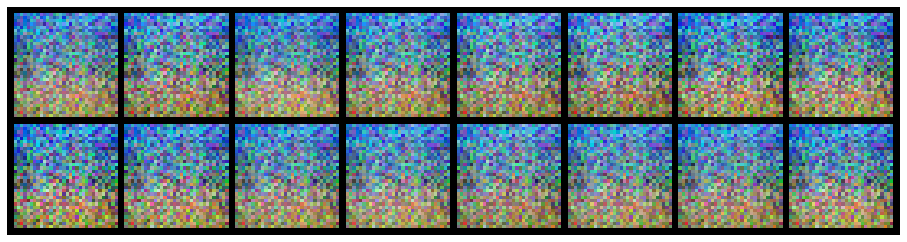

Epoch: [59/200], Batch Num: [0/13]
Discriminator Loss: 0.2673, Generator Loss: 3.8861
D(x): 0.9309, D(G(z)): 0.1349


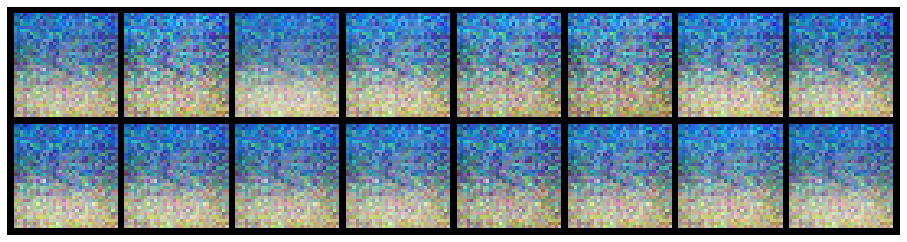

Epoch: [60/200], Batch Num: [0/13]
Discriminator Loss: 0.4614, Generator Loss: 2.5170
D(x): 0.8501, D(G(z)): 0.1471


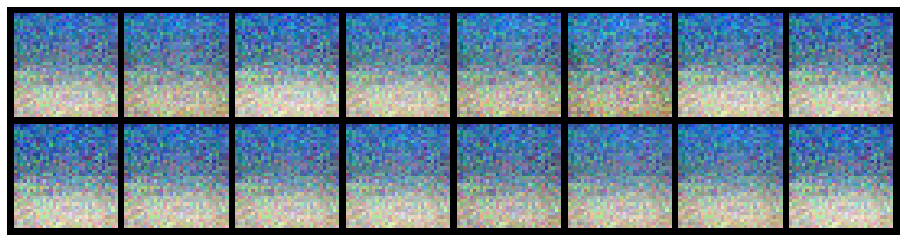

Epoch: [61/200], Batch Num: [0/13]
Discriminator Loss: 0.6422, Generator Loss: 1.7014
D(x): 0.8643, D(G(z)): 0.2990


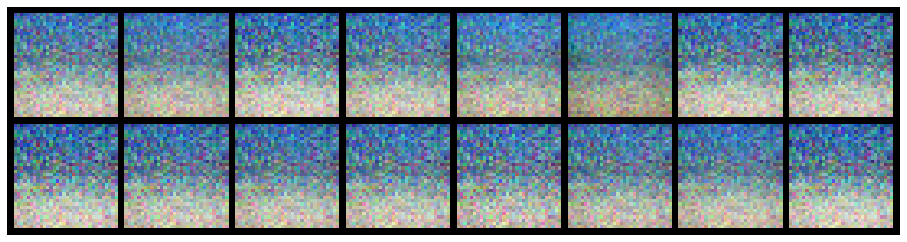

Epoch: [62/200], Batch Num: [0/13]
Discriminator Loss: 0.2975, Generator Loss: 2.8427
D(x): 0.9502, D(G(z)): 0.1847


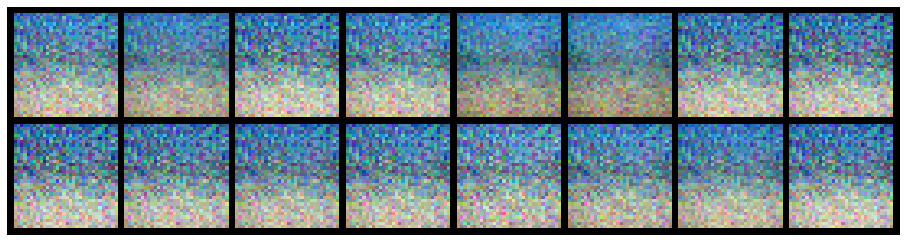

Epoch: [63/200], Batch Num: [0/13]
Discriminator Loss: 0.3049, Generator Loss: 2.6597
D(x): 0.9593, D(G(z)): 0.1700


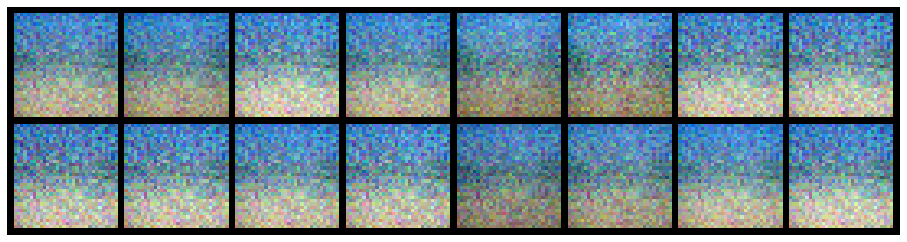

Epoch: [64/200], Batch Num: [0/13]
Discriminator Loss: 0.4799, Generator Loss: 2.0966
D(x): 0.9003, D(G(z)): 0.2249


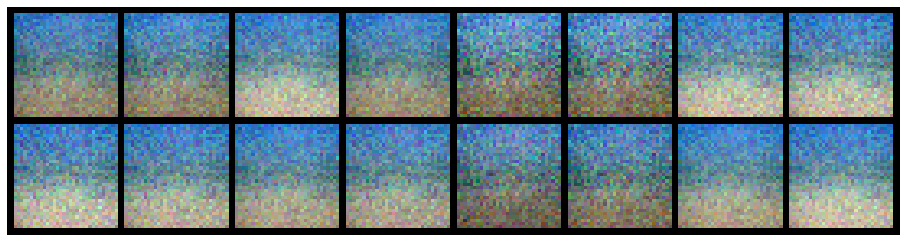

Epoch: [65/200], Batch Num: [0/13]
Discriminator Loss: 0.3384, Generator Loss: 2.4601
D(x): 0.9154, D(G(z)): 0.1715


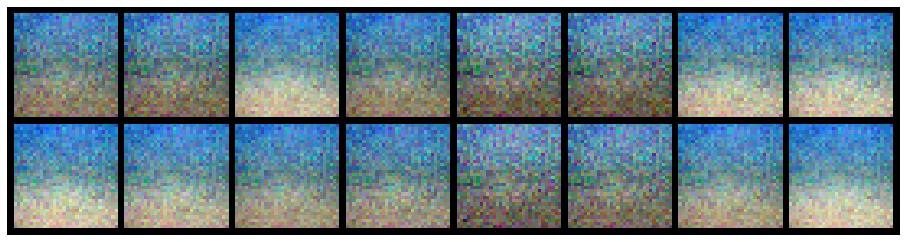

Epoch: [66/200], Batch Num: [0/13]
Discriminator Loss: 0.6222, Generator Loss: 1.9100
D(x): 0.9011, D(G(z)): 0.2864


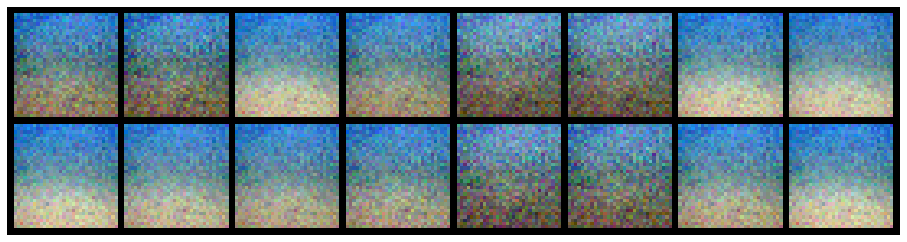

Epoch: [67/200], Batch Num: [0/13]
Discriminator Loss: 0.3348, Generator Loss: 2.6582
D(x): 0.9151, D(G(z)): 0.1377


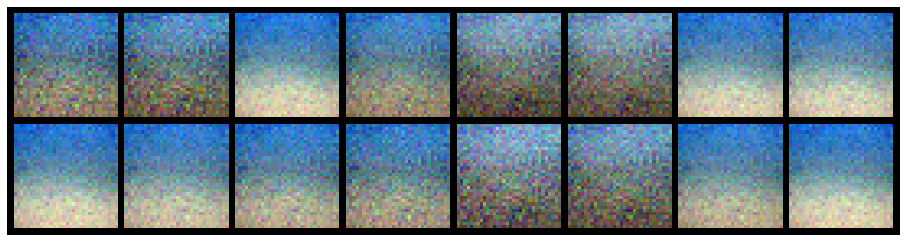

Epoch: [68/200], Batch Num: [0/13]
Discriminator Loss: 0.4886, Generator Loss: 1.8527
D(x): 0.9096, D(G(z)): 0.2532


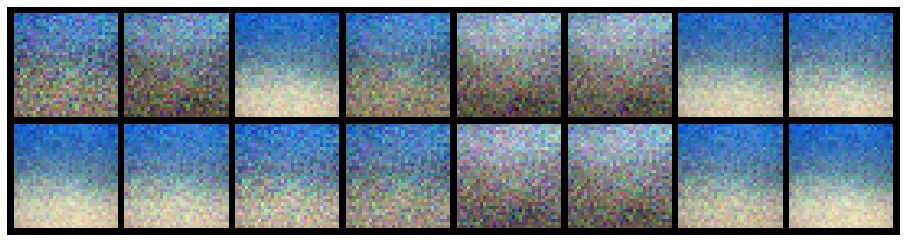

Epoch: [69/200], Batch Num: [0/13]
Discriminator Loss: 0.7088, Generator Loss: 1.9908
D(x): 0.8720, D(G(z)): 0.2777


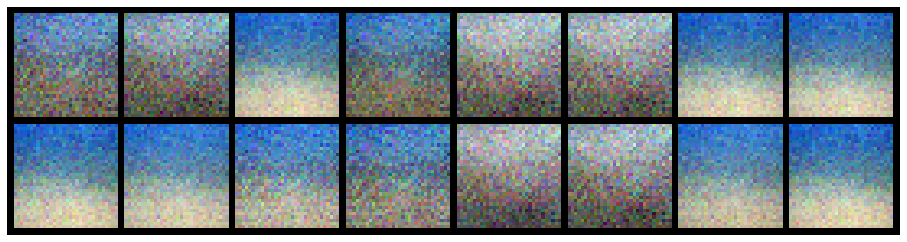

Epoch: [70/200], Batch Num: [0/13]
Discriminator Loss: 0.6476, Generator Loss: 1.9001
D(x): 0.8982, D(G(z)): 0.2735


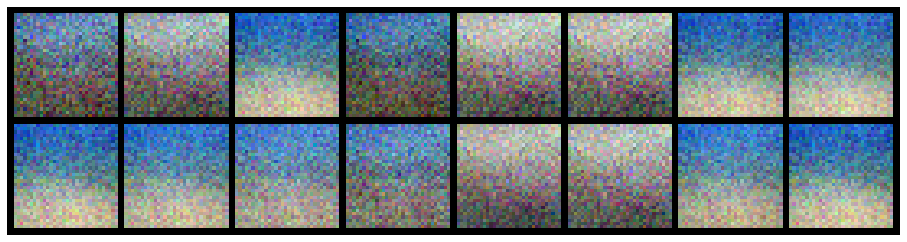

Epoch: [71/200], Batch Num: [0/13]
Discriminator Loss: 0.5988, Generator Loss: 1.9064
D(x): 0.9101, D(G(z)): 0.3422


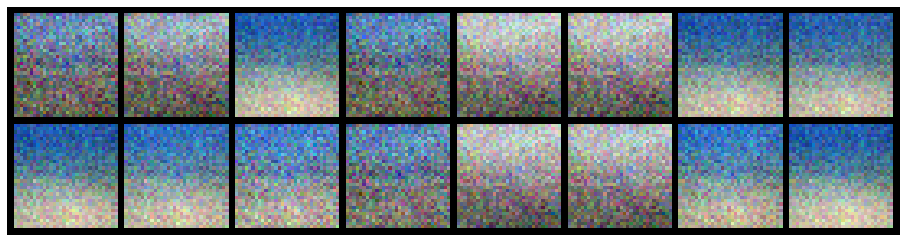

Epoch: [72/200], Batch Num: [0/13]
Discriminator Loss: 0.3560, Generator Loss: 2.6190
D(x): 0.9381, D(G(z)): 0.2109


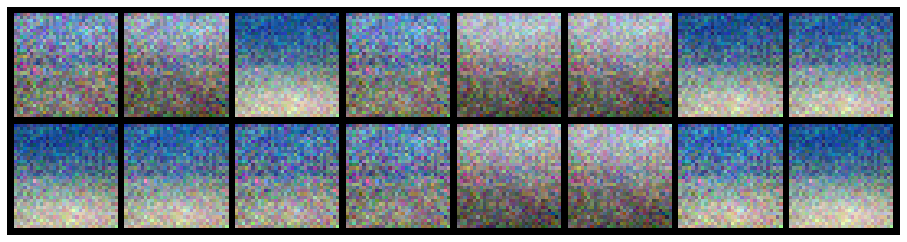

Epoch: [73/200], Batch Num: [0/13]
Discriminator Loss: 0.5310, Generator Loss: 2.2367
D(x): 0.8833, D(G(z)): 0.2213


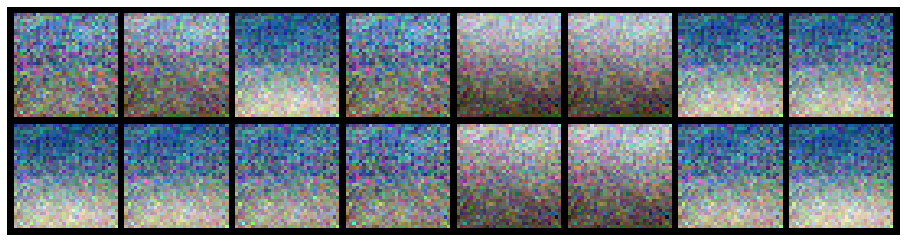

Epoch: [74/200], Batch Num: [0/13]
Discriminator Loss: 0.2634, Generator Loss: 2.9211
D(x): 0.9461, D(G(z)): 0.1491


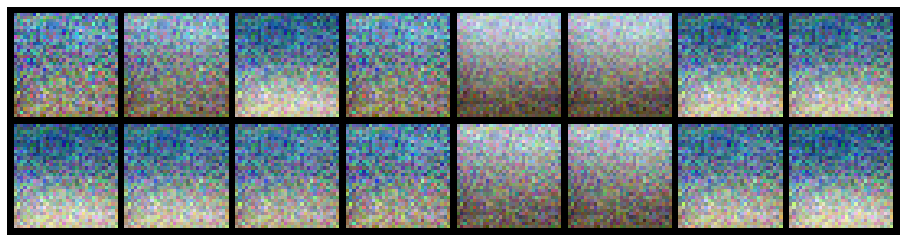

Epoch: [75/200], Batch Num: [0/13]
Discriminator Loss: 0.4148, Generator Loss: 2.8924
D(x): 0.9264, D(G(z)): 0.1804


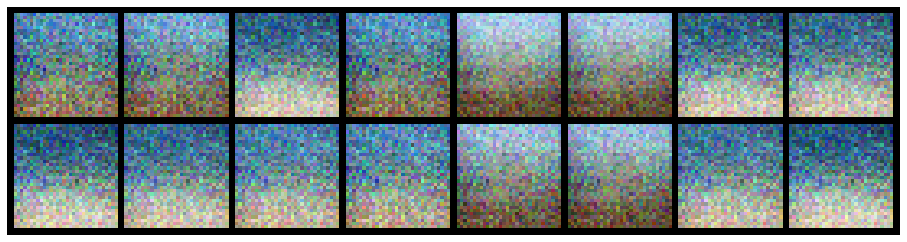

Epoch: [76/200], Batch Num: [0/13]
Discriminator Loss: 0.6290, Generator Loss: 2.7217
D(x): 0.8866, D(G(z)): 0.2955


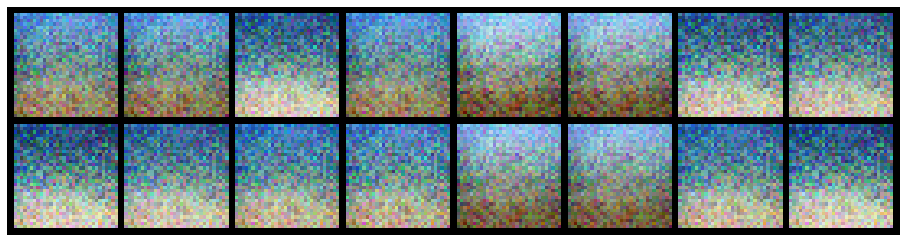

Epoch: [77/200], Batch Num: [0/13]
Discriminator Loss: 0.9716, Generator Loss: 4.6756
D(x): 0.7794, D(G(z)): 0.2455


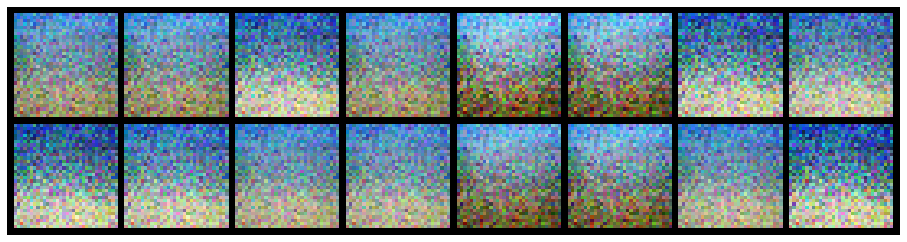

Epoch: [78/200], Batch Num: [0/13]
Discriminator Loss: 1.1515, Generator Loss: 5.0564
D(x): 0.7570, D(G(z)): 0.3096


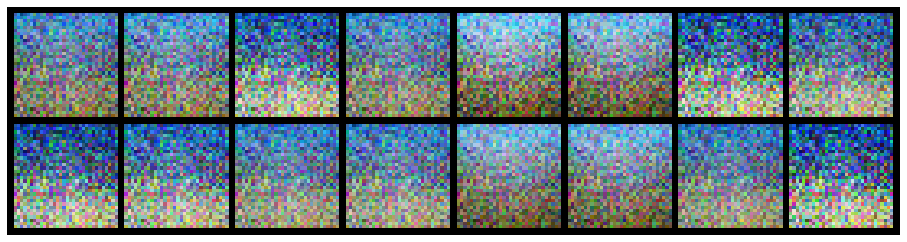

Epoch: [79/200], Batch Num: [0/13]
Discriminator Loss: 0.3853, Generator Loss: 5.8189
D(x): 0.8893, D(G(z)): 0.1334


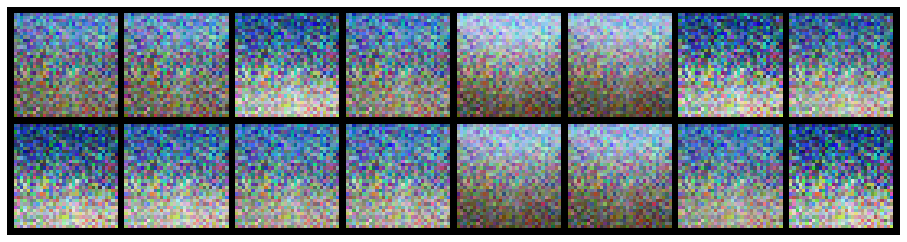

Epoch: [80/200], Batch Num: [0/13]
Discriminator Loss: 0.7595, Generator Loss: 4.2449
D(x): 0.8464, D(G(z)): 0.1933


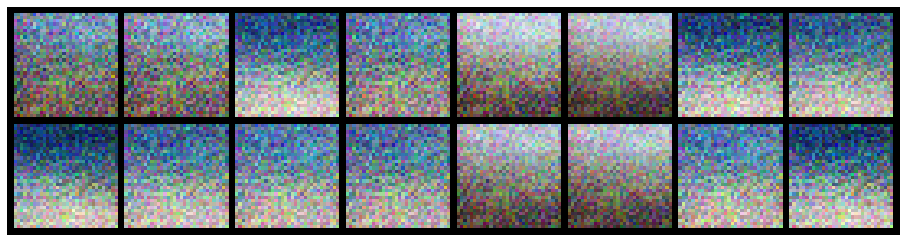

Epoch: [81/200], Batch Num: [0/13]
Discriminator Loss: 0.9667, Generator Loss: 3.0673
D(x): 0.8803, D(G(z)): 0.4418


KeyboardInterrupt: 

In [23]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

# Run Model on Random Latent Vector

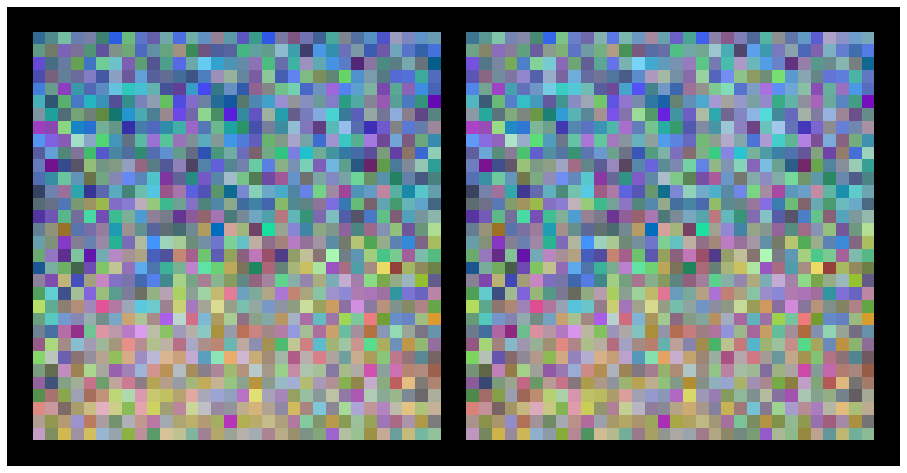

In [45]:
gen_noise = noise(1)

latent_vectors = [
        [ 1,  0.2916, -0.5201,  0.9904, -1.4158, -0.5420, -1.9516, -0.2472,
         -0.9724,  0.5958, -1.2964, -0.3477, -2.1218, -0.1649, -0.1988, -0.1854,
         -0.2385,  0.0711, -0.4181,  0.0370, -1.0068,  0.1739, -0.3058, -1.2550,
          0.0062,  0.4389,  0.9183,  0.2307,  1.0400, -0.4660,  0.5921,  0.2737,
         -1.1335,  0.5316, -0.6591, -0.7795,  1.1904, -1.0369, -1.1650,  0.1122,
         -0.1185,  1.1832, -1.3423, -1.0910, -1.3588, -0.5294, -0.1480,  0.5145,
         -0.1042, -0.4867, -1.6933, -0.5481,  0.4494, -0.5691, -1.4918,  0.4785,
         -0.0256,  0.7855, -0.8297, -1.1112, -1.0747, -0.2839,  0.4158,  0.7135,
          0.7279, -0.2009,  1.3327,  0.2775,  1.8480, -0.5222, -0.0402, -0.1771,
         -0.9966, -0.6635, -1.2545,  0.0576, -0.4051, -0.1903, -0.0065,  0.5102,
         -0.0220,  0.6534, -0.0202, -0.4121,  1.6525, -1.7544, -0.3790,  1.0990,
         -0.0573, -0.5831, -0.1564, -1.4115,  0.2456, -0.1517, -2.0059,  0.7284,
         -0.4869,  0.9339, -0.5881, -1.7136],
        [ -1,  0.2916, -0.5201,  0.9904, -1.4158, -0.5420, -1.9516, -0.2472,
         -0.9724,  0.5958, -1.2964, -0.3477, -2.1218, -0.1649, -0.1988, -0.1854,
         -0.2385,  0.0711, -0.4181,  0.0370, -1.0068,  0.1739, -0.3058, -1.2550,
          0.0062,  0.4389,  0.9183,  0.2307,  1.0400, -0.4660,  0.5921,  0.2737,
         -1.1335,  0.5316, -0.6591, -0.7795,  1.1904, -1.0369, -1.1650,  0.1122,
         -0.1185,  1.1832, -1.3423, -1.0910, -1.3588, -0.5294, -0.1480,  0.5145,
         -0.1042, -0.4867, -1.6933, -0.5481,  0.4494, -0.5691, -1.4918,  0.4785,
         -0.0256,  0.7855, -0.8297, -1.1112, -1.0747, -0.2839,  0.4158,  0.7135,
          0.7279, -0.2009,  1.3327,  0.2775,  1.8480, -0.5222, -0.0402, -0.1771,
         -0.9966, -0.6635, -1.2545,  0.0576, -0.4051, -0.1903, -0.0065,  0.5102,
         -0.0220,  0.6534, -0.0202, -0.4121,  1.6525, -1.7544, -0.3790,  1.0990,
         -0.0573, -0.5831, -0.1564, -1.4115,  0.2456, -0.1517, -2.0059,  0.7284,
         -0.4869,  0.9339, -0.5881, -1.7136]
                  
                  ]

tensor = torch.tensor(latent_vectors)

fake_data = generator(tensor)
test_images = vectors_to_images(fake_data)
test_images = test_images.data
logger.log_images(
                test_images, 1, 
                1, 1, 1
            );